Task2: Stacking Different Models
- Use Oversampling XG_Boost as final estimator
- Use Following different  models as base :

  - Overampling xgb (use hyperparameters from file provided)
  - Oversampling mlp (use hyperparameters from file provided)
  - Cost Sensitive logreg (use hyperparameters from file provided)
  
Only fine tune the final model                              
                              
                              


# Install Libraries

In [ ]:
%%capture
!pip install feature-engine
!pip install imblearn
!pip install xgboost

# Import Libraries


In [ ]:
#from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.dummy import DummyClassifier
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, precision_recall_curve, auc, f1_score, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve, train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold, RepeatedKFold
from sklearn.pipeline import Pipeline as sk_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import set_config
set_config(display="diagram")

from imblearn.pipeline import Pipeline as imb_pipeline
from imblearn.over_sampling import SMOTE

from feature_engine.imputation import MeanMedianImputer
from feature_engine.transformation import YeoJohnsonTransformer
from feature_engine.outliers import Winsorizer
from feature_engine.wrappers import SklearnTransformerWrapper

from xgboost import XGBClassifier

import scipy.stats as st

# Learning Curve Function

In [ ]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, return_times=True, random_state=123)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std, fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    return plt

# Import Dataset

In [ ]:
#drive.mount('/content/drive/')

In [ ]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# EDA

In [ ]:
print(train_data.shape)
print(test_data.shape)

(24846, 31)
(24846, 30)


In [ ]:
train_data.head(5)

,Id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,Target
0,138662,-0.711273,1.272483,1.681631,0.039897,-0.312381,-1.161083,0.853875,-0.173979,-0.438558,...,-0.208181,-0.414631,0.057957,0.930321,-0.165598,0.038799,0.384295,0.192762,21.87,0
1,235999,1.990679,-0.128465,-1.700556,0.529839,0.136889,-1.404270,0.593353,-0.456700,0.648260,...,0.018179,0.179084,-0.004248,0.039531,0.333765,-0.225201,-0.047285,-0.059682,49.99,0
2,245376,1.812653,-0.476162,-0.338988,1.386750,-0.745965,-0.449870,-0.492226,0.029904,1.129394,...,0.252668,0.655719,0.090057,-0.136884,-0.172452,-0.556921,0.036490,-0.021575,79.00,0
3,202483,-1.014219,0.522775,-0.337978,-1.957797,3.578395,3.266965,0.602857,0.644645,-0.305879,...,0.147742,0.590740,-0.680551,0.745346,1.119496,0.013520,0.004530,-0.132643,6.00,0
4,9710,-0.967270,-0.053815,2.273463,-0.894434,0.728924,0.153524,-0.038330,0.165252,1.172526,...,0.106692,0.514430,-0.081546,-0.305042,-0.354883,0.896254,-0.182293,-0.142810,15.95,0


In [ ]:
test_data.head(5)

,Id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29
0,83172,-2.033519,-1.079309,1.972553,-1.377534,-0.773444,0.702919,-0.870868,1.082417,-0.789931,...,0.536853,0.300559,0.409305,0.119931,-0.295053,0.331692,-0.277494,0.184017,-0.076897,141.01
1,140094,1.125524,0.189854,1.508660,2.719937,-0.882342,0.128390,-0.622651,0.219444,0.255370,...,-0.225172,-0.097584,-0.172683,0.057556,0.360859,0.265443,-0.040417,0.036686,0.033685,0.00
2,116283,-0.578027,1.109673,1.231751,0.725871,0.139675,-0.030415,0.770472,0.072078,-0.793572,...,0.097561,0.214610,0.773072,-0.110802,0.248029,-0.326140,-0.330373,0.321788,0.198050,43.25
3,222830,1.914017,0.588986,-1.481645,3.515009,1.271977,0.502868,0.536994,-0.055564,-1.452582,...,-0.179258,0.010252,0.020996,0.026001,0.186830,0.288364,-0.004518,-0.073108,-0.063333,30.67
4,60185,1.267642,0.725939,-0.091806,2.370915,0.420349,-0.570252,0.534720,-0.235391,-0.977075,...,-0.172138,-0.052174,-0.176550,-0.161225,-0.123870,0.787280,0.100856,-0.041856,0.004038,1.21


## Check Datatypes

In [ ]:
train_data.dtypes

Id          int64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
V29       float64
Target      int64
dtype: object

## Drop columns

*ID columns is an index. Dropping the column*

In [ ]:
del(train_data['Id'])
del(test_data['Id'])

In [ ]:
print(train_data.head(1))
print(test_data.head(1))

         V1        V2        V3        V4        V5        V6        V7  \
0 -0.711273  1.272483  1.681631  0.039897 -0.312381 -1.161083  0.853875   

         V8        V9       V10  ...       V21       V22       V23       V24  \
0 -0.173979 -0.438558 -0.053805  ... -0.208181 -0.414631  0.057957  0.930321   

        V25       V26       V27       V28    V29  Target  
0 -0.165598  0.038799  0.384295  0.192762  21.87       0  

[1 rows x 30 columns]
         V1        V2        V3        V4        V5        V6        V7  \
0 -2.033519 -1.079309  1.972553 -1.377534 -0.773444  0.702919 -0.870868   

         V8        V9      V10  ...       V20       V21       V22       V23  \
0  1.082417 -0.789931 -0.42377  ...  0.536853  0.300559  0.409305  0.119931   

        V24       V25       V26       V27       V28     V29  
0 -0.295053  0.331692 -0.277494  0.184017 -0.076897  141.01  

[1 rows x 29 columns]


## Distribution of Classes in Target Variable

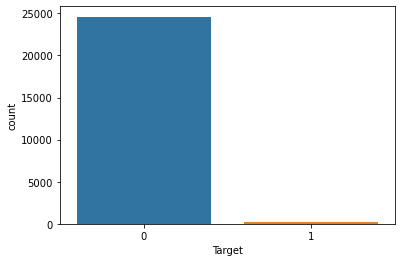

[0 1]
0    24602
1      244
Name: Target, dtype: int64


In [ ]:
sns.countplot(x = train_data['Target'])
plt.show()
print(train_data['Target'].unique())
print(train_data['Target'].value_counts())

## NULL Values

In [ ]:
print(train_data.isnull().sum())

V1        2387
V2           0
V3           0
V4           0
V5           0
V6           0
V7           0
V8           0
V9           0
V10          0
V11          0
V12          0
V13          0
V14          0
V15          0
V16          0
V17          0
V18          0
V19          0
V20       2529
V21          0
V22          0
V23          0
V24          0
V25          0
V26          0
V27          0
V28          0
V29          0
Target       0
dtype: int64


In [ ]:
var_impute = ['V1','V20']

In [ ]:
train_data.dropna(axis=0).shape

(20167, 30)

## Descriptive Statistics

In [ ]:
train_data.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,Target
count,22459.000000,24846.000000,24846.000000,24846.000000,24846.000000,24846.000000,24846.000000,24846.000000,24846.000000,24846.000000,...,24846.000000,24846.000000,24846.000000,24846.000000,24846.000000,24846.000000,24846.000000,24846.000000,24846.000000,24846.000000
mean,-0.042032,0.019074,-0.055260,0.029289,-0.031085,-0.008175,-0.026007,0.014152,-0.017939,-0.035149,...,0.004708,0.006116,-0.004320,-0.005632,0.003193,0.001730,0.003160,-0.000100,91.698618,0.009820
std,2.061469,1.722647,1.730072,1.482053,1.616062,1.413044,1.620777,1.236557,1.140772,1.279021,...,0.753043,0.728869,0.622440,0.602507,0.518214,0.483415,0.455299,0.314326,310.349300,0.098613
min,-37.054295,-39.818310,-48.325589,-5.231828,-113.743307,-19.996349,-37.060311,-39.688571,-11.126624,-23.228255,...,-21.620120,-8.887017,-23.222016,-2.759942,-4.930750,-1.658162,-7.976100,-15.430084,0.000000,0.000000
25%,-0.941997,-0.611444,-0.918977,-0.853705,-0.705745,-0.778707,-0.565469,-0.207270,-0.659425,-0.543054,...,-0.225318,-0.528751,-0.163086,-0.363609,-0.310198,-0.325839,-0.069698,-0.053829,5.470000,0.000000
50%,0.002750,0.068992,0.163070,-0.006193,-0.070299,-0.279575,0.032157,0.026507,-0.056063,-0.094353,...,-0.026834,0.016988,-0.011396,0.036837,0.020346,-0.049872,0.001493,0.010855,21.990000,0.000000
75%,1.309469,0.825253,1.016704,0.759149,0.598372,0.402585,0.569205,0.335042,0.586035,0.454624,...,0.192690,0.533115,0.147343,0.433292,0.352613,0.241366,0.093725,0.079364,77.900000,0.000000
max,2.418267,19.167239,3.862590,15.304184,28.762671,73.301626,120.589494,19.587773,8.918202,15.331742,...,27.202839,8.272233,17.606637,4.584549,4.554683,3.415636,31.612198,15.522649,25691.160000,1.000000


## Diagnostic Plots

In [ ]:
def diagnostic_plots(df, variable, classification = True):
  if classification:
    col = 4
  else:
    col = 3
  plt.figure(figsize=(16, 3))
  plt.subplot(1, col, 1)
  sns.histplot(df[variable], bins=30)
  plt.title('Histogram')
  plt.subplot(1, col, 2)
  sns.boxplot(y=df[variable])
  plt.title('Boxplot')
  if classification:
    plt.subplot(1, col, 3)
    sns.boxplot(x=df['Target'], y=df[variable])
    plt.title('Boxplot')
    plt.subplot(1, col, 4)
    st.probplot(df[variable], dist="norm", plot=plt)
    plt.title('Q-Q plot')
    plt.show()
  else:
    plt.subplot(1, col, 3)
    st.probplot(df[variable], dist="norm", plot=plt)
    plt.title('Q-Q plot')
    plt.show()

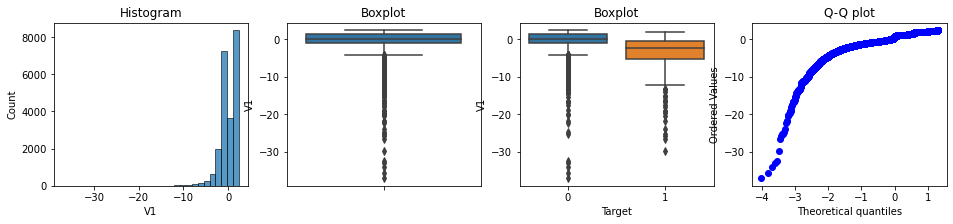

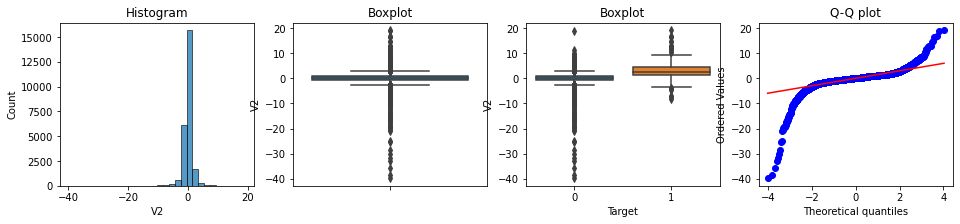

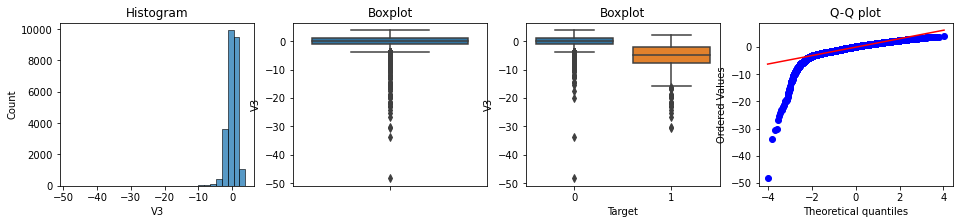

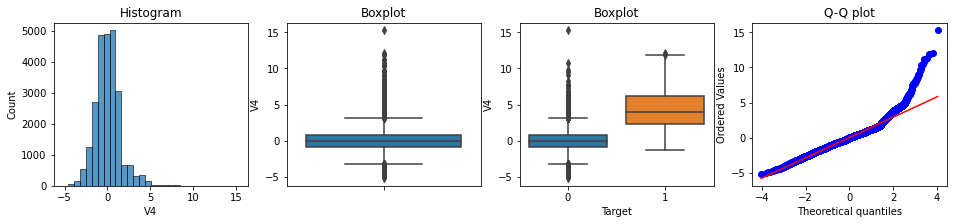

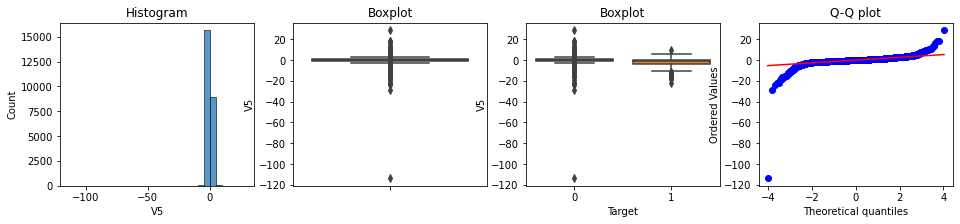

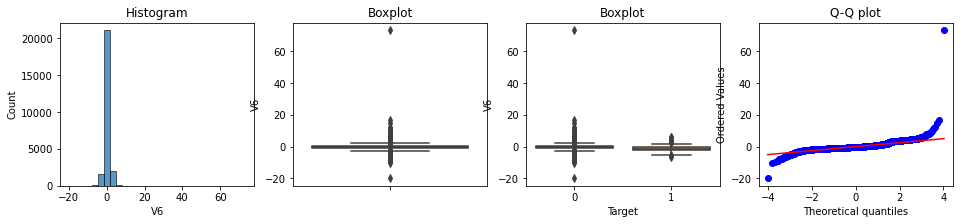

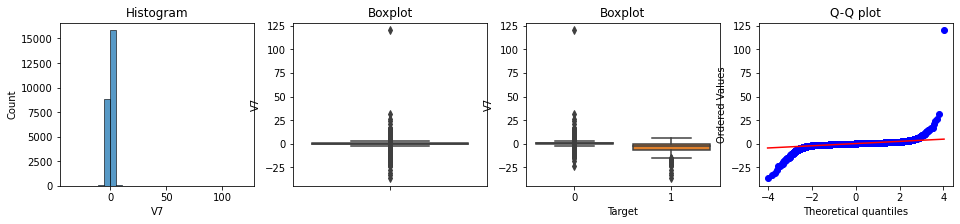

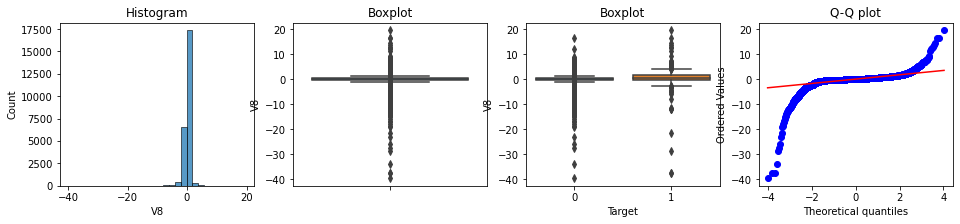

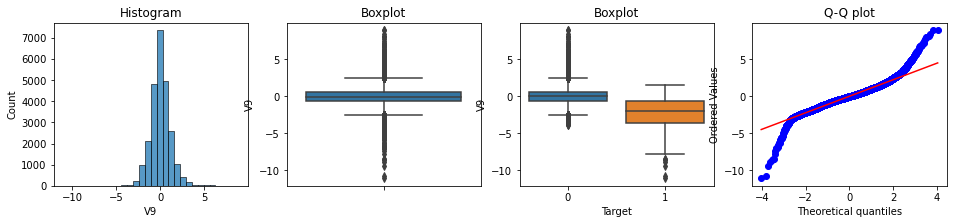

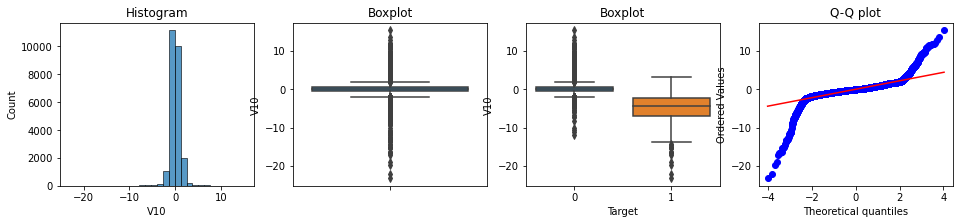

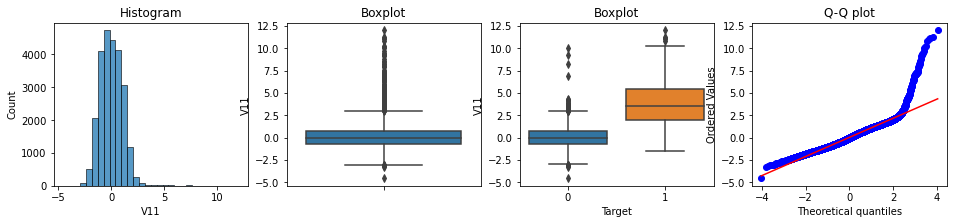

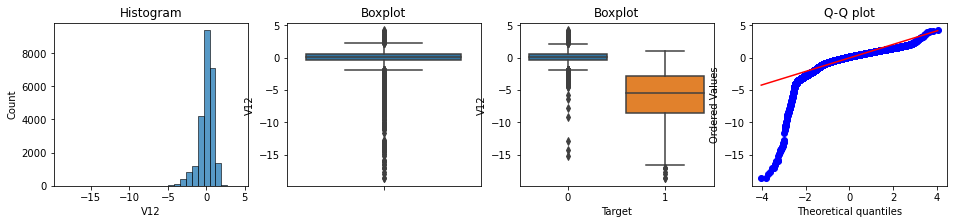

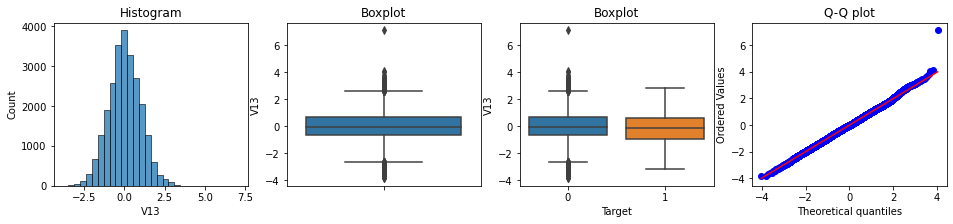

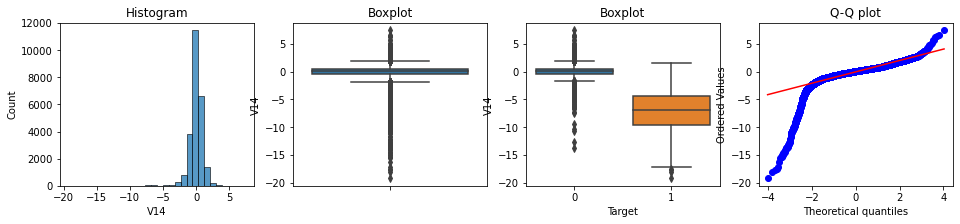

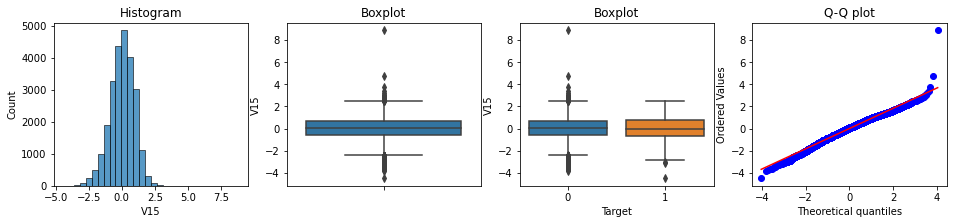

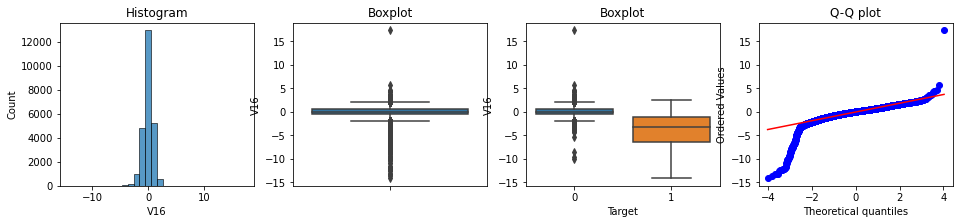

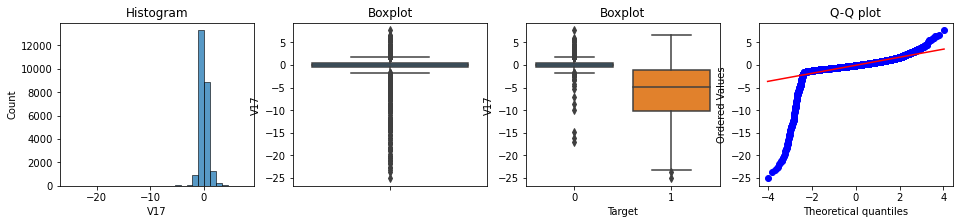

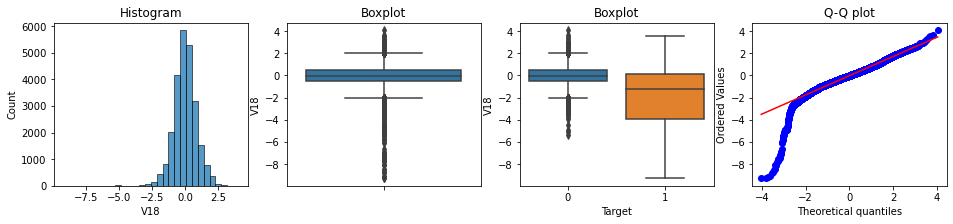

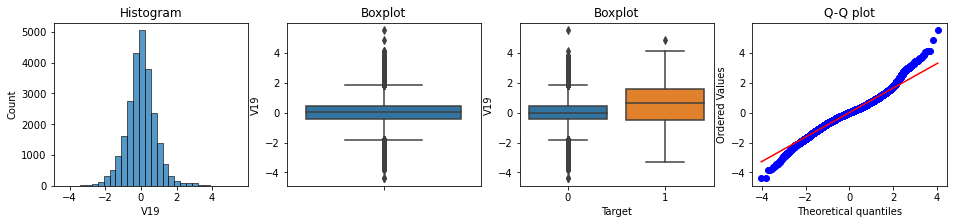

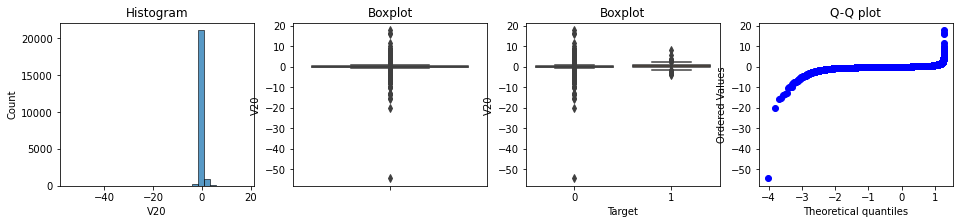

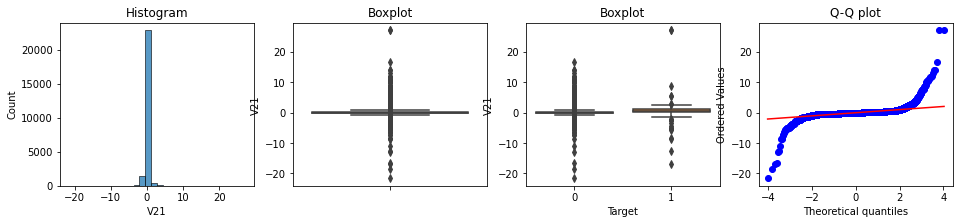

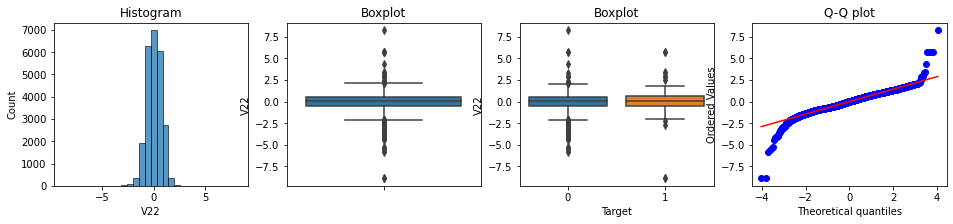

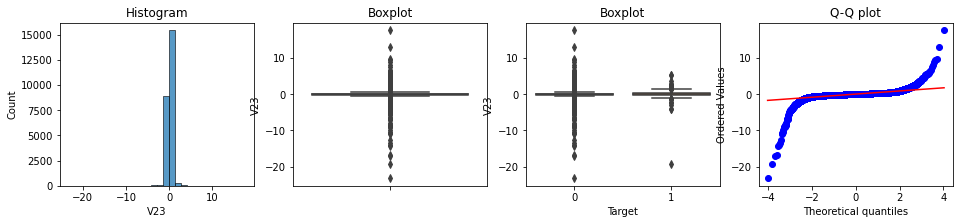

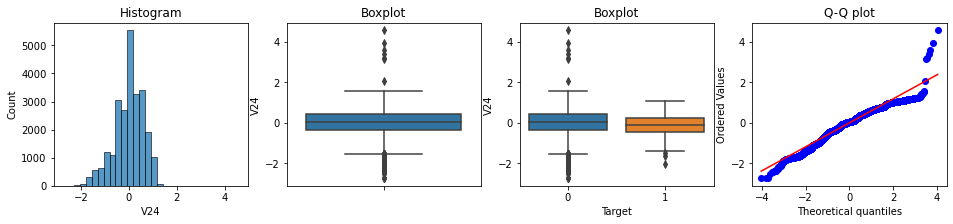

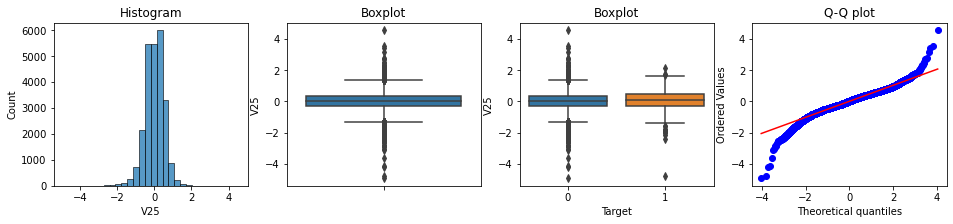

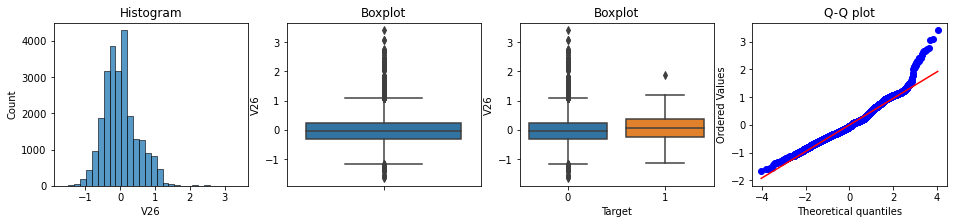

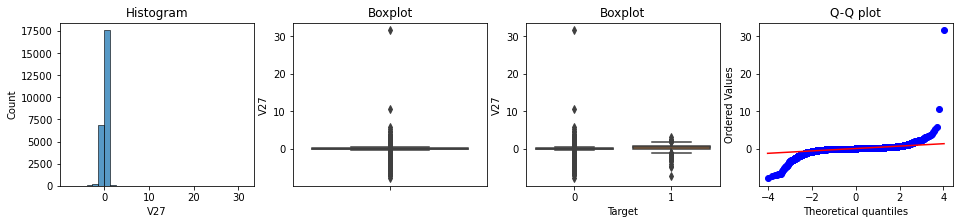

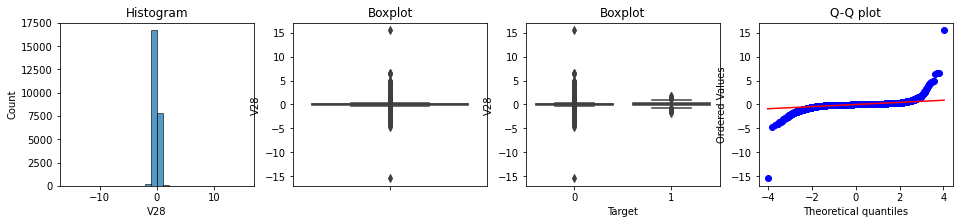

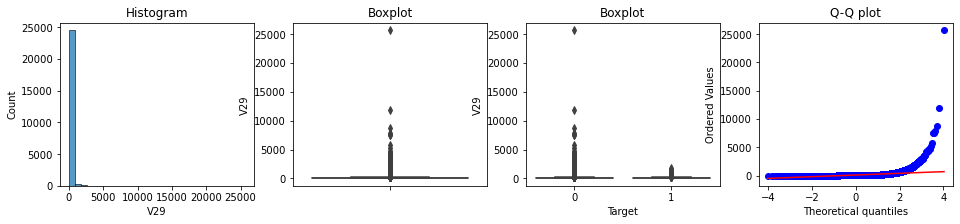

In [ ]:
for var in train_data.columns.tolist()[:-1]:
    diagnostic_plots(train_data,var)

## Correlation between all variables

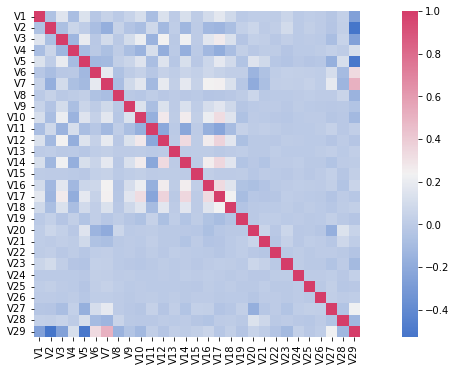

In [ ]:
corr = train_data.drop(columns=['Target']).corr(method='pearson')
plt.figure(figsize=(15,6))
cmap = sns.diverging_palette(255, 0, as_cmap=True)
sns.heatmap(corr, square=True, cmap=cmap)
plt.show()

## Correlation between highly correlated individual variables

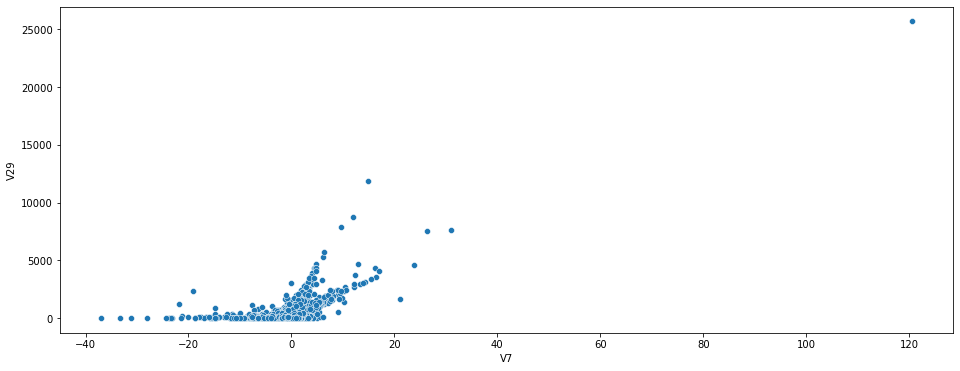

In [ ]:
plt.figure(figsize=(16, 6))
sns.scatterplot(x = train_data['V7'], y = train_data['V29'])
plt.show()

## Check outliers

In [ ]:
Q1 = train_data.drop(columns=['Target']).quantile(0.25)
Q3 = train_data.drop(columns=['Target']).quantile(0.75)
IQR = Q3 - Q1
((train_data.drop(columns=['Target']) < Q1 - (1.5 * IQR)) | (train_data.drop(columns=['Target']) > Q3 + (1.5 * IQR))).any()

V1     True
V2     True
V3     True
V4     True
V5     True
V6     True
V7     True
V8     True
V9     True
V10    True
V11    True
V12    True
V13    True
V14    True
V15    True
V16    True
V17    True
V18    True
V19    True
V20    True
V21    True
V22    True
V23    True
V24    True
V25    True
V26    True
V27    True
V28    True
V29    True
dtype: bool

# Conclusions from EDA

* *There are 24846 observations and 30 variables in the training dataset. Target variable is has binary classes 1 and 0*<br>
* *Datatype of all independent varibales is float*<br>
* *ID is an index column, it has been dropped*<br>
* *Target variable is highly imbalanced with minority class being just 0.98% of data. We will use oversampling to balance the class*<br>
* *There are NULL values in the dataset. Dropping NULL values will reduce the dataset by 16%. We will impute the NULL values with median imputer since there are outliers in the dataset*<br>
* *Mean and Median of variables from V1 to V28 is close to 0*<br>
* *Except V13 and V15, other independent variables are skewed, we will use Yeo-Johnson transformation*<br>
* *None of the variables are highly correlated*<br>
* *There are outliers in all independent variables*<br>

# Train Validation Split

In [ ]:
y_train_val = train_data['Target']
X_train_val = train_data.drop(columns=['Target'])
X_test = test_data
X_train, X_val, y_train, y_val = train_test_split(X_train_val, 
                                                  y_train_val, 
                                                  test_size = 0.2,
                                                  random_state = 123)

In [ ]:
print(f'Training Data Shape: {train_data.shape}')
print(f'X_Train Shape: {X_train.shape}')
print(f'y_Train Shape: {y_train.shape}')
print(f'X_Validation Shape: {X_val.shape}')
print(f'y_Validation Shape: {y_val.shape}')
print(f'X_Test Shape: {X_test.shape}')
print(f'y_Train Value Counts:\n {y_train.value_counts()}')
print(f'y_Validation Value Counts:\n {y_val.value_counts()}')

Training Data Shape: (24846, 30)
X_Train Shape: (19876, 29)
y_Train Shape: (19876,)
X_Validation Shape: (4970, 29)
y_Validation Shape: (4970,)
X_Test Shape: (24846, 29)
y_Train Value Counts:
 0    19673
1      203
Name: Target, dtype: int64
y_Validation Value Counts:
 0    4929
1      41
Name: Target, dtype: int64


# Dummy Classifier

In [ ]:
dc_ub = DummyClassifier(strategy="stratified", random_state=123)
dc_ub.fit(X_train, y_train)
dc_ub_y_val_pred = dc_ub.predict(X_val)
dc_ub.score(X_val, y_val)

0.9828973843058351

In [ ]:
scoring = ['accuracy','balanced_accuracy']
cv_result = cross_validate(dc_ub, X_train, 
                           y_train, 
                           scoring=scoring, 
                           cv=5,
                           return_train_score=True, 
                           return_estimator=True)
print(f'Train Accuracy: {cv_result["train_accuracy"].mean()}')
print(f'Validation Accuracy: {cv_result["test_accuracy"].mean()}')
print(f'Train Bal Accuracy: {cv_result["train_balanced_accuracy"].mean()}')
print(f'Validation Bal Accuracy: {cv_result["test_balanced_accuracy"].mean()}')

Train Accuracy: 0.9816109915954023
Validation Accuracy: 0.9809820938207864
Train Bal Accuracy: 0.5019679140672952
Validation Bal Accuracy: 0.4955522797053543


# Pipeline 1

* *Handling Missing Values - Median imputer*<br>
* *Handling Imbalance - Oversampling to balance the class in training data*<br>
* *Power transformation - Yeo-Johnson transformation*<br>
* *Handling of Outliers - Winsorizer*<br>
* *Handling Scale of Variables - MinMaxScaler*<br>

## XGB Pipeline

In [ ]:
%%capture
pipeline_xgb_1 = imb_pipeline([('imputer', MeanMedianImputer(imputation_method='median',variables=var_impute)),
                               ('oversampler',SMOTE(sampling_strategy='auto',random_state=123)),
                               ('xgb_model',XGBClassifier(random_state=42,early_stopping_rounds=2))])
param_grid_xgb_1 = {'xgb_model__max_depth': [5],
                    'xgb_model__n_estimators': [60],
                    'xgb_model__subsample': [0.9]}
xgb_grid_1 = GridSearchCV(pipeline_xgb_1,param_grid_xgb_1,return_train_score=True)
xgb_grid_1.fit(X_train,y_train)

In [ ]:
print(f'Best Paramters: {xgb_grid_1.best_params_}')
print(f'Best Score: {xgb_grid_1.best_score_}')
print(f'Training Score: {xgb_grid_1.score(X_train,y_train)}')
print(f'Validation Score: {xgb_grid_1.score(X_val,y_val)}')

Best Paramters: {'xgb_model__max_depth': 5, 'xgb_model__n_estimators': 60, 'xgb_model__subsample': 0.9}
Best Score: 0.9971825291370866
Training Score: 1.0
Validation Score: 0.9977867203219316


## MLP Pipeline

In [ ]:
pipeline_mlp_1 = imb_pipeline([('imputer', MeanMedianImputer(imputation_method='median',variables=var_impute)),
                               ('oversampler',SMOTE(sampling_strategy='auto',random_state=123)),
                               ('transformer',YeoJohnsonTransformer(variables=X_train.columns.to_list())),
                               ('winsorizer',Winsorizer(variables=X_train.columns.to_list())),
                               ('scaler',MinMaxScaler()),
                               ('mlp_model',MLPClassifier(random_state=123,max_iter=400))])
param_grid_mlp_1 = {'mlp_model__alpha': [0.9],
                    'mlp_model__solver': ['sgd']}
mlp_grid_1 = GridSearchCV(pipeline_mlp_1,param_grid_mlp_1,return_train_score=True)
mlp_grid_1.fit(X_train,y_train)
print(f'Best Paramters: {mlp_grid_1.best_params_}')
print(f'Best Score: {mlp_grid_1.best_score_}')
print(f'Training Score: {mlp_grid_1.score(X_train,y_train)}')
print(f'Validation Score: {mlp_grid_1.score(X_val,y_val)}')

Best Paramters: {'mlp_model__alpha': 0.9, 'mlp_model__solver': 'sgd'}
Best Score: 0.983598521949306
Training Score: 0.9839504930569531
Validation Score: 0.9849094567404426


## Logreg Pipeline

In [ ]:
pipeline_lr_1 = imb_pipeline([('imputer', MeanMedianImputer(imputation_method='median',variables=var_impute)),
                               ('transformer',YeoJohnsonTransformer(variables=X_train.columns.to_list())),
                               ('winsorizer',Winsorizer(variables=X_train.columns.to_list())),
                               ('scaler',MinMaxScaler()),
                               ('lr_model',LogisticRegression(C=0.01, class_weight={0: 1, 1: 10},penalty='l2'))])
param_grid_lr_1 = {'lr_model__C': [0.01],
                   'lr_model__class_weight': [{0: 1, 1: 10}],
                   'lr_model__penalty': ['l2'],}
lr_grid_1 = GridSearchCV(pipeline_lr_1,param_grid_lr_1,return_train_score=True)
lr_grid_1.fit(X_train,y_train)
print(f'Best Paramters: {lr_grid_1.best_params_}')
print(f'Best Score: {lr_grid_1.best_score_}')
print(f'Training Score: {lr_grid_1.score(X_train,y_train)}')
print(f'Validation Score: {lr_grid_1.score(X_val,y_val)}')

Best Paramters: {'lr_model__C': 0.01, 'lr_model__class_weight': {0: 1, 1: 10}, 'lr_model__penalty': 'l2'}
Best Score: 0.9952706427242701
Training Score: 0.9955725498088146
Validation Score: 0.9963782696177063


# Stacking Classifier with Pipeline 1

In [ ]:
estimators = [('xgb',xgb_grid_1.best_estimator_),
              ('mlp',mlp_grid_1.best_estimator_),
              ('lr',lr_grid_1.best_estimator_)]
final_estimator = XGBClassifier(random_state=123, early_stopping_rounds=2)
cv = StratifiedKFold(random_state=123, shuffle=True)

## Hyperparameter tuning round 1

In [ ]:
%%capture
sclf_1 = StackingClassifier(estimators=estimators, 
                          final_estimator=final_estimator,
                          cv=cv)
params_1 = {
              'final_estimator__max_depth' : np.arange(2,23,4),
              'final_estimator__n_estimators' : np.arange(0,250,50),
              'final_estimator__learning_rate' : np.arange(0.1,1,0.1),
              'final_estimator__min_child_weight' : np.arange(0,10,1),
              'final_estimator__subsample': np.arange(0.1,1,0.1),
              'stack_method':['auto', 'predict_proba']
             }
sclf1_grid = RandomizedSearchCV(sclf_1, params_1,cv=cv, return_train_score=True)
sclf1_grid.fit(X_train,y_train)

In [ ]:
print(f'Best Paramters: {sclf1_grid.best_params_}')
print(f'Best Score: {sclf1_grid.best_score_}')
print(f'Training Score: {sclf1_grid.score(X_train,y_train)}')
print(f'Validation Score: {sclf1_grid.score(X_val,y_val)}')

Best Paramters: {'stack_method': 'auto', 'final_estimator__subsample': 0.1, 'final_estimator__n_estimators': 150, 'final_estimator__min_child_weight': 3, 'final_estimator__max_depth': 22, 'final_estimator__learning_rate': 0.5}
Best Score: 0.9978365539146831
Training Score: 1.0
Validation Score: 0.9983903420523139


<module 'matplotlib.pyplot' from 'C:\\Users\\Vikash Kumar\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

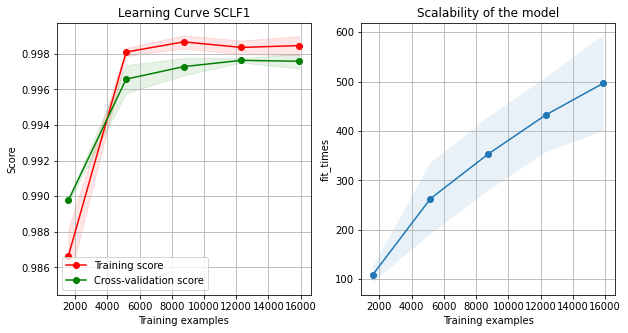

In [ ]:
plot_learning_curve(sclf1_grid.best_estimator_,'Learning Curve SCLF1',X_train,y_train,n_jobs=-1)

## Hyperparameter tuning round 2

In [ ]:
%%capture
params_2 = {
              'final_estimator__max_depth' : [20,21,22,23,24],
              'final_estimator__n_estimators' : np.arange(40,60,2),
              'final_estimator__learning_rate' : np.arange(0.3,0.5,0.025),
              'final_estimator__min_child_weight' : np.arange(3,5,.2),
              'final_estimator__subsample': [0.9,0.92,0.94,0.96,0.98],
              'stack_method':['predict_proba']
             }
sclf2_grid = RandomizedSearchCV(sclf_1, params_2,cv=cv, return_train_score=True)
sclf2_grid.fit(X_train,y_train)

Best Paramters: {'stack_method': 'predict_proba', 'final_estimator__subsample': 0.96, 'final_estimator__n_estimators': 46, 'final_estimator__min_child_weight': 4.000000000000001, 'final_estimator__max_depth': 22, 'final_estimator__learning_rate': 0.4000000000000001}
Best Score: 0.9975850195512699
Training Score: 0.9990943851881666
Validation Score: 0.9981891348088531


<module 'matplotlib.pyplot' from 'C:\\Users\\Vikash Kumar\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

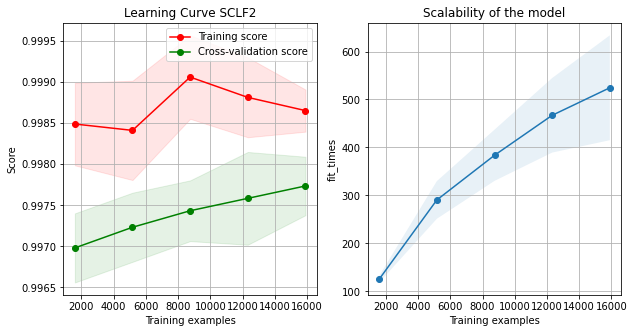

In [ ]:
print(f'Best Paramters: {sclf2_grid.best_params_}')
print(f'Best Score: {sclf2_grid.best_score_}')
print(f'Training Score: {sclf2_grid.score(X_train,y_train)}')
print(f'Validation Score: {sclf2_grid.score(X_val,y_val)}')
plot_learning_curve(sclf2_grid.best_estimator_,'Learning Curve SCLF2',X_train,y_train,n_jobs=-1)

## All rounds scores

In [ ]:
pd.DataFrame(data=[[sclf1_grid.best_score_, sclf2_grid.best_score_],
                   [sclf1_grid.score(X_train,y_train), sclf2_grid.score(X_train,y_train)],
                   [sclf1_grid.score(X_val,y_val), sclf2_grid.score(X_val,y_val)]],
             index=['Best Score', 'Training Score', 'Validation Score'],
             columns=['SCLF1', 'SCLF2'])

,SCLF1,SCLF2
Best Score,0.997837,0.997585
Training Score,1.000000,0.999094
Validation Score,0.998390,0.998189


# Pipeline 2

In [ ]:
%%capture
pipeline_xgb_2 = imb_pipeline([('imputer', MeanMedianImputer(imputation_method='median',variables=var_impute)),
                               ('oversampler',SMOTE(sampling_strategy='auto',random_state=123)),
                               ('xgb_model',XGBClassifier(random_state=42,early_stopping_rounds=2))])
param_grid_xgb_2 = {'xgb_model__max_depth': [5],
                    'xgb_model__n_estimators': [60],
                    'xgb_model__subsample': [0.9]}
xgb_grid_2 = GridSearchCV(pipeline_xgb_2,param_grid_xgb_2,return_train_score=True)
xgb_grid_2.fit(X_train,y_train)
pipeline_mlp_2 = imb_pipeline([('imputer', MeanMedianImputer(imputation_method='median',variables=var_impute)),
                               ('winsorizer',Winsorizer(variables=X_train.columns.to_list())),
                               ('transformer',YeoJohnsonTransformer(variables=X_train.columns.to_list())),
                               ('scaler',MinMaxScaler()),
                               ('oversampler',SMOTE(sampling_strategy='auto',random_state=123)),
                               ('mlp_model',MLPClassifier(random_state=123,max_iter=400))])
param_grid_mlp_2 = {'mlp_model__alpha': [0.9],
                    'mlp_model__solver': ['sgd']}
mlp_grid_2 = GridSearchCV(pipeline_mlp_2,param_grid_mlp_2,return_train_score=True)
mlp_grid_2.fit(X_train,y_train)
pipeline_lr_2 = imb_pipeline([('imputer', MeanMedianImputer(imputation_method='median',variables=var_impute)),
                               ('transformer',YeoJohnsonTransformer(variables=X_train.columns.to_list())),
                               ('winsorizer',Winsorizer(variables=X_train.columns.to_list())),
                               ('scaler',MinMaxScaler()),
                               ('lr_model',LogisticRegression(C=0.01, class_weight={0: 1, 1: 10},penalty='l2'))])
param_grid_lr_2 = {'lr_model__C': [0.01],
                   'lr_model__class_weight': [{0: 1, 1: 10}],
                   'lr_model__penalty': ['l2'],}
lr_grid_2 = GridSearchCV(pipeline_lr_2,param_grid_lr_2,return_train_score=True)
lr_grid_2.fit(X_train,y_train)
estimators = [('xgb',xgb_grid_2.best_estimator_),
              ('mlp',mlp_grid_2.best_estimator_),
              ('lr',lr_grid_2.best_estimator_)]
final_estimator = XGBClassifier(random_state=123, early_stopping_rounds=2)
cv = StratifiedKFold(random_state=123, shuffle=True)

C:\Users\Vikash Kumar\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:45:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:45:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Vikash Kumar\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:45:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:45:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Vikash Kumar\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:45:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:45:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Vikash Kumar\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:45:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:45:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Vikash Kumar\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:45:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:45:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Vikash Kumar\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:45:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:45:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
print(f'XGB Best Paramters: {xgb_grid_2.best_params_}')
print(f'XGB Best Score: {xgb_grid_2.best_score_}')
print(f'XGB Training Score: {xgb_grid_2.score(X_train,y_train)}')
print(f'XGB Validation Score: {xgb_grid_2.score(X_val,y_val)}')

print(f'MLP Best Paramters: {mlp_grid_2.best_params_}')
print(f'MLP Best Score: {mlp_grid_2.best_score_}')
print(f'MLP Training Score: {mlp_grid_2.score(X_train,y_train)}')
print(f'MLP Validation Score: {mlp_grid_2.score(X_val,y_val)}')

print(f'Logreg Best Paramters: {lr_grid_2.best_params_}')
print(f'Logreg Best Score: {lr_grid_2.best_score_}')
print(f'Logreg Training Score: {lr_grid_2.score(X_train,y_train)}')
print(f'Logreg Validation Score: {lr_grid_2.score(X_val,y_val)}')

XGB Best Paramters: {'xgb_model__max_depth': 5, 'xgb_model__n_estimators': 60, 'xgb_model__subsample': 0.9}
XGB Best Score: 0.9971825291370866
XGB Training Score: 1.0
XGB Validation Score: 0.9977867203219316
MLP Best Paramters: {'mlp_model__alpha': 0.9, 'mlp_model__solver': 'sgd'}
MLP Best Score: 0.9822400313832681
MLP Training Score: 0.9824411350372309
MLP Validation Score: 0.9837022132796781
Logreg Best Paramters: {'lr_model__C': 0.01, 'lr_model__class_weight': {0: 1, 1: 10}, 'lr_model__penalty': 'l2'}
Logreg Best Score: 0.9952706427242701
Logreg Training Score: 0.9955725498088146
Logreg Validation Score: 0.9963782696177063


## Hyperparameter tuning round 1

In [ ]:
%%capture
sclf_21 = StackingClassifier(estimators=estimators, 
                          final_estimator=final_estimator,
                          cv=cv)
params_21 = {
              'final_estimator__max_depth' : np.arange(2,23,4),
              'final_estimator__n_estimators' : np.arange(0,250,50),
              'final_estimator__learning_rate' : np.arange(0.1,1,0.1),
              'final_estimator__min_child_weight' : np.arange(0,10,1),
              'final_estimator__subsample': np.arange(0.1,1,0.1),
              'stack_method':['auto', 'predict_proba']
             }
sclf21_grid = RandomizedSearchCV(sclf_21, params_21,cv=cv, return_train_score=True)
sclf21_grid.fit(X_train,y_train)

Best Paramters: {'stack_method': 'predict_proba', 'final_estimator__subsample': 0.30000000000000004, 'final_estimator__n_estimators': 100, 'final_estimator__min_child_weight': 4, 'final_estimator__max_depth': 6, 'final_estimator__learning_rate': 0.2}
Best Score: 0.9977359376384092
Training Score: 0.9993962567921111
Validation Score: 0.9983903420523139


<module 'matplotlib.pyplot' from 'C:\\Users\\Vikash Kumar\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

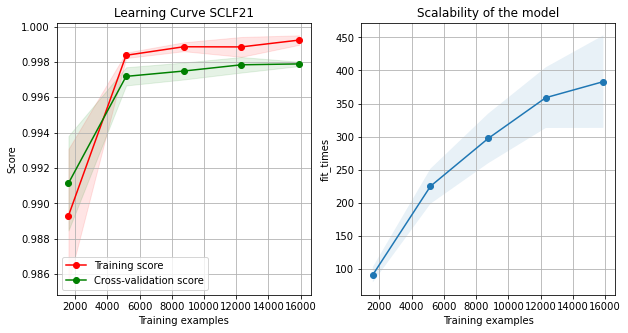

In [ ]:
print(f'Best Paramters: {sclf21_grid.best_params_}')
print(f'Best Score: {sclf21_grid.best_score_}')
print(f'Training Score: {sclf21_grid.score(X_train,y_train)}')
print(f'Validation Score: {sclf21_grid.score(X_val,y_val)}')
plot_learning_curve(sclf21_grid.best_estimator_,'Learning Curve SCLF21',X_train,y_train,n_jobs=-1)

# Prediction on Test Data

In [ ]:
y_pred_pipeline_1 = sclf2_grid.predict(X_test)
y_pred_pipeline_2 = sclf21_grid.predict(X_test)

In [ ]:
pd.DataFrame(y_pred_pipeline_1).value_counts()

0    24625
1      221
dtype: int64

In [ ]:
pd.DataFrame(y_pred_pipeline_2).value_counts()

0    24624
1      222
dtype: int64

# Save models for future use

In [ ]:
import joblib
from pathlib import Path

In [ ]:
save_model_folder  = Path('Models')

In [ ]:
pl_1_hp_1_est = save_model_folder / 'file2_pl_1_hp_1_est.pkl'
pl_1_hp_2_est = save_model_folder / 'file2_pl_1_hp_2_est.pkl'
pl_2_hp_1_est = save_model_folder / 'file2_pl_2_hp_1_est.pkl'

pl_1_hp_1_grid = save_model_folder / 'file2_pl_1_hp_1_grid.pkl'
pl_1_hp_2_grid = save_model_folder / 'file2_pl_1_hp_2_grid.pkl'
pl_2_hp_1_grid = save_model_folder / 'file2_pl_2_hp_1_grid.pkl'

joblib.dump(sclf1_grid.best_estimator_, pl_1_hp_1_est)
joblib.dump(sclf2_grid.best_estimator_, pl_1_hp_2_est)
joblib.dump(sclf21_grid.best_estimator_, pl_2_hp_1_est)

joblib.dump(sclf1_grid, pl_1_hp_1_grid)
joblib.dump(sclf2_grid, pl_1_hp_2_grid)
joblib.dump(sclf21_grid, pl_2_hp_1_grid)

['Models\\file2_pl_2_hp_1_grid.pkl']